In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Import NO2 data

In [3]:
data=pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/ad_viz_plotval_data.csv')

In [4]:
data['Daily Max 1-hour NO2 Concentration'].describe()


count    3208.000000
mean       32.335006
std        13.560984
min         4.400000
25%        22.000000
50%        32.000000
75%        41.000000
max       100.000000
Name: Daily Max 1-hour NO2 Concentration, dtype: float64

Text(0.5, 1.0, 'Newark Fire Station NO2 concentration')

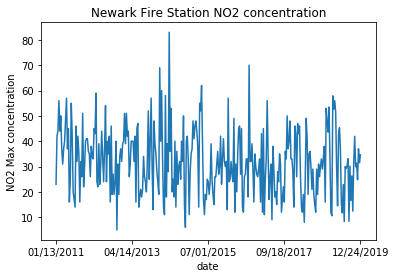

In [5]:
plt.plot(data['Date'][::10],data['Daily Max 1-hour NO2 Concentration'][::10])
plt.xticks(data['Date'][0::800]);
plt.xlabel('date')
plt.ylabel('NO2 Max concentration');
plt.title('Newark Fire Station NO2 concentration')

## Plot Autocorrelation Functions

In [6]:
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

def plot_lag(df,feature,lag,ax=None):
    df = make_lag_df(df,feature,lag).dropna()
    if ax:
        ax.scatter(df[feature+'_lag'],df[feature])

        ax.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        ax.set_title("lag = " + str(lag),fontsize=12)
    else:
        plt.scatter(df[feature+'_lag'],df[feature])

        plt.plot(np.linspace(350,550,10),
                np.linspace(350,550,10),
               'k--', alpha = .6)

        plt.show()

def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

In [87]:
data_train= data.iloc[:-365,].copy()
data_test = data.drop(data_train.index).copy()

In [88]:
lags = np.arange(0,10,1)
print([get_autocorr(data_train,'Daily Max 1-hour NO2 Concentration',lag) for lag in lags])

[1.0, 0.40528052087480937, 0.15045939608783487, 0.13935415094417136, 0.17125724542873005, 0.15690986866737286, 0.19811621215910802, 0.20610313718593262, 0.17867050108863525, 0.14714844395360008]


In [89]:
data_diff=pd.DataFrame(data_train['Daily Max 1-hour NO2 Concentration'].diff()).dropna().reset_index(drop=True)

In [90]:
data_diff=pd.DataFrame(data_train['Daily Max 1-hour NO2 Concentration'].diff()).dropna().reset_index(drop=True)

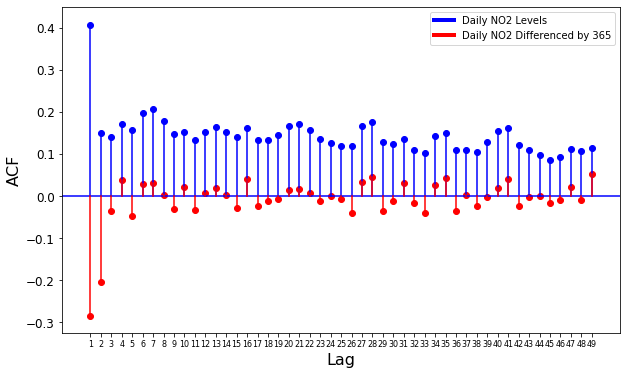

In [91]:
## Plotting block
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4)]


n=50

data_autos = []

# get the autocorr.
for i in range(1,n,1):
    data_autos.append(get_autocorr(data_train,'Daily Max 1-hour NO2 Concentration',i))

# make a figure
plt.figure(figsize=(10,6))

# plot a horizontal line
plt.axhline(y=0, xmin=0, xmax=n, color = "blue")

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           data_autos,
           c='b')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,data_autos[i-1]],'b')

# Add labels
plt.xlabel("Lag", fontsize=16)
plt.ylabel("ACF", fontsize=16)

# set tick marks
plt.xticks(np.arange(1,n,1), fontsize=8)
plt.yticks(fontsize=12)


data_diff_autos = []

# get the autocorr for the diff data

for i in range(1,n,1):
    data_diff_autos.append(get_autocorr(data_diff,'Daily Max 1-hour NO2 Concentration',i))

# plot each autocorrelation against the lag
plt.scatter(range(1,n,1), 
           data_diff_autos,
           c='r')

# Plot vertical lines
for i in range(1,n,1):
    plt.plot(i*np.ones(2),[0,data_diff_autos[i-1]],'r')
    
plt.legend(custom_lines, ['Daily NO2 Levels', 'Daily NO2 Differenced by 365'])

plt.show()

## Plot Seasonal Projections

In [96]:
from statsmodels.tsa.api import ExponentialSmoothing

In [97]:
add_mod = ExponentialSmoothing(data_train['Daily Max 1-hour NO2 Concentration'],seasonal_periods=365, seasonal='add')

mul_mod = ExponentialSmoothing(data_train['Daily Max 1-hour NO2 Concentration'],seasonal_periods=365, seasonal='mul')

In [94]:
add_mod_fit = add_mod.fit()

# The multiplicative model
mul_mod_fit = mul_mod.fit()

C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\plame\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


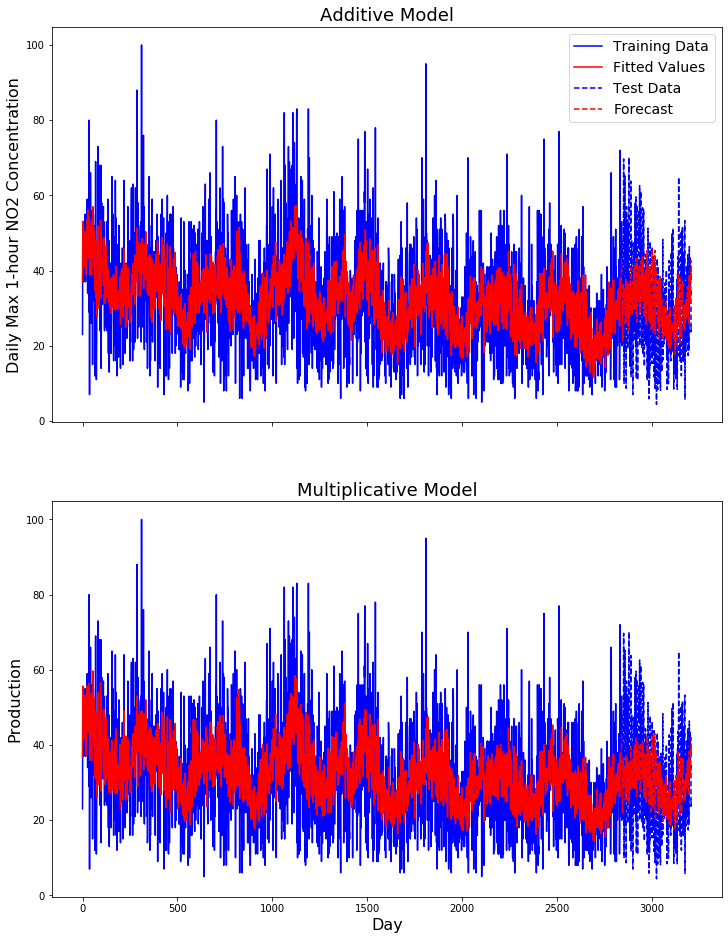

In [95]:
## Plot Them
fig,ax = plt.subplots(2,1,figsize=(12,16),sharex=True, sharey=True)

## The additive model
# training data
ax[0].plot(data_train['Daily Max 1-hour NO2 Concentration'].index, data_train['Daily Max 1-hour NO2 Concentration'].values, 
           'b-', label="Training Data")

# fitted values
ax[0].plot(data_train['Daily Max 1-hour NO2 Concentration'].index, add_mod_fit.fittedvalues, 
           'r-', label="Fitted Values")

# The test data
ax[0].plot(data_test['Daily Max 1-hour NO2 Concentration'].index, data_test['Daily Max 1-hour NO2 Concentration'].values,
            'b--', label="Test Data")
ax[0].plot(data_test['Daily Max 1-hour NO2 Concentration'].index, add_mod_fit.forecast(len(data_test['Daily Max 1-hour NO2 Concentration'])),
           'r--', label="Forecast")

ax[0].legend(fontsize=14)

ax[0].set_title("Additive Model",fontsize=18)
ax[0].set_ylabel('Daily Max 1-hour NO2 Concentration',fontsize=16)



## The multiplicative model
# training data
ax[1].plot(data_train['Daily Max 1-hour NO2 Concentration'].index, data_train['Daily Max 1-hour NO2 Concentration'].values, 
           'b-', label="Training Data")

# fitted values
ax[1].plot(data_train['Daily Max 1-hour NO2 Concentration'].index, mul_mod_fit.fittedvalues, 
           'r-', label="Fitted Values")

# The test data
ax[1].plot(data_test['Daily Max 1-hour NO2 Concentration'].index, data_test['Daily Max 1-hour NO2 Concentration'].values,
            'b--', label="Test Data")
ax[1].plot(data_test['Daily Max 1-hour NO2 Concentration'].index, mul_mod_fit.forecast(len(data_test['Daily Max 1-hour NO2 Concentration'])),
           'r--', label="Forecast")


ax[1].set_title("Multiplicative Model",fontsize=18)
ax[1].set_ylabel("Production",fontsize=16)
ax[1].set_xlabel("Day",fontsize=16)

plt.show()

## List of Data Stations

In [51]:
sites=pd.read_csv('https://raw.githubusercontent.com/yilmazduygu/gretta-grettas/master/aqs_sites.csv')

In [52]:
sites[(sites["State Name"]=="New Jersey") & (sites["City Name"]=='Newark')].head()

,State Code,County Code,Site Number,Latitude,Longitude,Datum,Elevation,Land Use,Location Setting,Site Established Date,...,Owning Agency,Local Site Name,Address,Zip Code,State Name,County Name,City Name,CBSA Name,Tribe Name,Extraction Date
11459,34,13,3,40.720989,-74.192892,WGS84,27.0,RESIDENTIAL,URBAN AND CENTER CITY,2009-06-01,...,New Jersey State Department Of Environmental P...,Newark Firehouse,360 Clinton Avenue,7108.0,New Jersey,Essex,Newark,"New York-Newark-Jersey City, NY-NJ-PA",NaN,2020-05-19
11460,34,13,4,40.742879,-74.180700,WGS84,15.0,RESIDENTIAL,URBAN AND CENTER CITY,1980-01-01,...,US EPA National Exposure Research Lab,NaN,FACULTY MEMORIAL HALL NJ INST. TECHNOLOG,NaN,New Jersey,Essex,Newark,"New York-Newark-Jersey City, NY-NJ-PA",NaN,2020-05-19
11461,34,13,5,40.737223,-74.175408,WGS84,9.0,COMMERCIAL,URBAN AND CENTER CITY,1968-01-01,...,New Jersey State Department Of Environmental P...,NaN,"TRAILER,WASHINGTON & MARKET STREETS",7102.0,New Jersey,Essex,Newark,"New York-Newark-Jersey City, NY-NJ-PA",NaN,2020-05-19
11462,34,13,6,40.736490,-74.175422,WGS84,9.0,COMMERCIAL,URBAN AND CENTER CITY,1973-01-01,...,New Jersey State Department Of Environmental P...,NaN,WASHINGTON STREET AND BRANFORD PLACE,NaN,New Jersey,Essex,Newark,"New York-Newark-Jersey City, NY-NJ-PA",NaN,2020-05-19
11463,34,13,7,40.740101,-74.164589,WGS84,9.0,COMMERCIAL,URBAN AND CENTER CITY,1978-01-01,...,New Jersey State Department Of Environmental P...,NaN,NORTHEAST CORNER OF MILITARY PARK,NaN,New Jersey,Essex,Newark,"New York-Newark-Jersey City, NY-NJ-PA",NaN,2020-05-19
